<a href="https://colab.research.google.com/github/jiachengma/NNProperty/blob/main/PINN_property_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install CoolProp

In [2]:
import torch
import torch.nn as nn
from torch.nn import MSELoss
import matplotlib.pyplot as plt
import numpy as np
from CoolProp.CoolProp import PropsSI
import CoolProp as CP
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pickle import dump

In [21]:
# from CoolProp.constants import HENRYS_LAW_TO_GENERATE_VLE_GUESSES
class PINNmodel(object):
    """
    Physics-informed neural networks for density, temperature, specific heat, and density partial derivatives w.r.t. (p, h)
    """
    def __init__(self, medium, p_max, p_min, h_max, h_min, net, criterion, normalizer):
        self.medium = medium
        self.p_max = p_max
        self.p_min = p_min
        self.h_max = h_max
        self.h_min = h_min
        self.net = net
        self.criterion = criterion
        self.normalizer = normalizer


    def generateSatData(self, n=100, phase='bubble'):
        p = self.p_min + (self.p_max - self.p_min) * np.random.rand(n) # input pressure
        q = 0 if phase=='bubble' else 1
        HEOS = CP.AbstractState("HEOS", self.medium)
        n_output = 8 # number of outputs
        output = np.zeros((n, n_output)) # d, h, T, s, dddp, dhdp, dTdp, dsdp
        for k in range(n):
          HEOS.update(CP.PQ_INPUTS, p[k], q)
          dddp = HEOS.first_saturation_deriv(CP.iDmass, CP.iP)
          dhdp = HEOS.first_saturation_deriv(CP.iHmass, CP.iP)
          dTdp = HEOS.first_saturation_deriv(CP.iT, CP.iP)
          dsdp = HEOS.first_saturation_deriv(CP.iSmass, CP.iP)
          output[k] = np.array([HEOS.rhomass(), HEOS.hmass(), HEOS.T(), HEOS.smass(), dddp, dhdp, dTdp, dsdp])
        return np.hstack((p[:,None], output))

    def generateSinglePhaseData(self, n_p, n_h, phase='liquid'):
        """
        Generate single-phase training data
        n_p     -- number of pressure samples
        n_h     -- number of enthalpy samples per pressure
        phase   -- liquid or vapor
        """
        p_range = self.p_min + (self.p_max - self.p_min) * np.random.rand(n_p)
        p_data = np.kron(p_range.reshape(-1,1), np.ones((1, n_h)))
        if phase == 'liquid':
          h_f = PropsSI('Hmass', 'P', p_range, 'Q', 0, self.medium)
          h_data = np.tile(h_f-self.h_min, (n_h,1)).T * np.random.rand(n_p, n_h) + self.h_min
        elif phase == 'vapor':
          h_g = PropsSI('Hmass', 'P', p_range, 'Q', 1, self.medium)
          h_data = np.tile(self.h_max - h_g, (n_h,1)).T * np.random.rand(n_p, n_h) + np.tile(h_g, (n_h,1)).T
        else:
          print('unknown phase')

        input_ph = np.stack((p_data.flatten(), h_data.flatten()), axis=1)
        HEOS = CP.AbstractState("HEOS", self.medium)
        output = np.zeros((n_p*n_h, 6)) # d, T, s, dddp_h, dddh_p, dTdh_p
        for k in range(output.shape[0]):
          HEOS.update(CP.HmassP_INPUTS, input_ph[k,1], input_ph[k,0])
          dddp = HEOS.first_partial_deriv(CP.iDmass, CP.iP, CP.iHmass)
          dddh = HEOS.first_partial_deriv(CP.iDmass, CP.iHmass, CP.iP)
          dTdh = HEOS.first_partial_deriv(CP.iT, CP.iHmass, CP.iP)
          output[k] = np.array([HEOS.rhomass(), HEOS.T(), HEOS.smass(), dddp, dddh, dTdh])
        return np.hstack((input_ph, output))

    def loss_sp(self, input, output, deriv, alpha):
      """single phase loss function"""
      input.requires_grad = True
      y = self.net(input)
      drho = torch.autograd.grad(y[:,0], input, grad_outputs=torch.ones_like(y[:,0]),
                                  create_graph=True)[0]
      dTdh = torch.autograd.grad(y[:,1], input, grad_outputs=torch.ones_like(y[:,1]),
                                  create_graph=True)[0][:,1:2]
      deriv_pred = torch.hstack((drho, dTdh))
      return self.criterion(y, output) + 10 * alpha * self.criterion(deriv[:,0:1], drho[:,0:1]) + alpha * self.criterion(deriv[:,1:2], drho[:,1:2]) + alpha * self.criterion(deriv[:,2:3], dTdh)

    def loss_sat(self, input, output, deriv, alpha):
      input.requires_grad = True
      y = self.net(input)
      dddp = torch.autograd.grad(y[:,0], input, grad_outputs=torch.ones_like(y[:,0]),
                                  create_graph=True)[0]
      dhdp = torch.autograd.grad(y[:,1], input, grad_outputs=torch.ones_like(y[:,1]),
                                  create_graph=True)[0]
      dTdp = torch.autograd.grad(y[:,2], input, grad_outputs=torch.ones_like(y[:,2]),
                                  create_graph=True)[0]
      dsdp = torch.autograd.grad(y[:,3], input, grad_outputs=torch.ones_like(y[:,3]),
                                  create_graph=True)[0]
      deriv_pred = torch.hstack((dddp, dhdp, dTdp, dsdp))
      return self.criterion(y, output) + alpha * self.criterion(torch.hstack((dddp, dhdp)), deriv[:,:2]) + alpha * self.criterion(torch.hstack((dTdp, dsdp)), deriv[:,2:])

    def train_pinn(self, epochs, loss_f, train_input, train_output, train_deriv, alpha):
      """train single phase media model"""
      optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    line_search_fn='strong_wolfe')
      def closure():
        optimizer.zero_grad()
        l = loss_f(train_input, train_output, train_deriv, alpha)
        l.backward()
        return l
      self.net.train()
      for iter in range(epochs):
        optimizer.step(closure)
        # run again to print loss
        ls_iter = closure()
        print(f'Epoch {iter+1}, Loss: {ls_iter.item()}')

    def normalize_sp(self, data):
      """ normalize single phase data"""
      data_prop = data[:,:5]
      data_deriv = data[:,5:]
      norm_prop = self.normalizer.fit_transform(data_prop) # normalized property data (p, h, d, T, s)
      scale = self.normalizer.scale_
      norm_deriv = np.stack((scale[2]/scale[0]*data_deriv[:,0], scale[2]/scale[1]*data_deriv[:,1], scale[3]/scale[1]*data_deriv[:,-1]), axis=1) # dddp, dddh, dTdh
      return (norm_prop[:,:2], norm_prop[:,2:], norm_deriv)

    def normalize_sat(self, data):
      """normalize saturated data"""
      data_prop = data[:,:5]
      data_deriv = data[:,5:]
      norm_prop = self.normalizer.fit_transform(data_prop)
      scale = self.normalizer.scale_
      norm_deriv = np.stack((scale[1]/scale[0]*data_deriv[:,0], scale[2]/scale[0]*data_deriv[:,1], scale[3]/scale[0]*data_deriv[:,2], scale[4]/scale[0]*data_deriv[:,3]), axis=1)
      return (norm_prop[:,0:1], norm_prop[:,1:], norm_deriv)

    def train_singlePhase(self, n_p=10, n_h=10, phase='liquid', epochs=10, alpha=0.1):
      if phase not in ['liquid', 'vapor']:
          raise Exception("phase input should be liquid or vapor")
      # generate data
      data = self.generateSinglePhaseData(n_p, n_h, phase)
      input_norm, output_norm, deriv_norm = self.normalize_sp(data)
      # training
      self.train_pinn(epochs, self.loss_sp, torch.from_numpy(input_norm).float(), torch.from_numpy(output_norm).float(), torch.from_numpy(deriv_norm).float(), alpha)

    def train_sat(self, n, phase='bubble', epochs=10, alpha=0.1):
      if phase not in ['bubble', 'dew']:
          raise Exception("phase input should be 'bubble' or 'dew'")
      # generate data
      data = self.generateSatData(n, phase)
      input_norm, output_norm, deriv_norm = self.normalize_sat(data)
      # training
      self.train_pinn(epochs, self.loss_sat, torch.from_numpy(input_norm).float(), torch.from_numpy(output_norm).float(), torch.from_numpy(deriv_norm).float(), alpha)

    def plot_validate(self, data_true, data_pred, titles=None):
      n = data_true.shape[1]
      fig, ax = plt.subplots(n, 1, figsize=(15, 20))
      for i in range(n):
        ax[i].plot(data_true[:,i], data_pred[:,i], '.')
        y_min = data_true[:,i].min()
        y_max = data_true[:,i].max()
        ax[i].plot(np.linspace(y_min, y_max), np.linspace(y_min, y_max))
        if titles:
          ax[i].set_title(titles[i])

    def validate_singlePhase(self, n_p=10, n_h=10, phase='liquid', criterion=None, plot=1):
      data = self.generateSinglePhaseData(n_p, n_h, phase)
      norm_prop = self.normalizer.transform(data[:,:5])
      input_norm = torch.from_numpy(norm_prop[:,:2]).float()
      output_true = data[:,2:5]
      input_norm.requires_grad = True
      self.net.eval()
      output_pred_norm = self.net(input_norm)
      scale = self.normalizer.scale_
      dd_pred_norm = torch.autograd.grad(output_pred_norm[:,0], input_norm, grad_outputs=torch.ones_like(output_pred_norm[:,0]), create_graph=True)[0]
      dddp_pred = dd_pred_norm[:,0:1] * scale[0] / scale[2]
      dddh_pred = dd_pred_norm[:,1:2] * scale[1] / scale[2]
      cp_pred = 1 / (torch.autograd.grad(output_pred_norm[:,1], input_norm, grad_outputs=torch.ones_like(output_pred_norm[:,1]), create_graph=True)[0][:,1:2]) * scale[3] / scale[1]
      output_pred = self.normalizer.inverse_transform(np.hstack((input_norm.detach().numpy(), output_pred_norm.detach().numpy())))[:,2:]
      error_output = criterion(output_true, output_pred, multioutput='raw_values')
      deriv_pred = np.hstack((dddp_pred.detach().numpy(), dddh_pred.detach().numpy(), cp_pred.detach().numpy()))
      deriv_true = np.hstack((data[:,5:-1], 1/data[:,-1:]))
      error_deriv = criterion(deriv_true, deriv_pred, multioutput='raw_values')
      print(f'MAPE for d, T, s: {error_output}, MAPE for dddp, dddh, cp: {error_deriv}')
      titles = ['d', 'T', 's', 'dddp_h', 'dddh_p', 'cp']
      if plot:
        self.plot_validate(np.hstack((output_true, deriv_true)), np.hstack((output_pred, deriv_pred)), titles)
      return (error_output, error_deriv)

    def validate_sat(self, n, phase, criterion=None, plot=1):
      data = self.generateSatData(n, phase)
      norm_prop = self.normalizer.transform(data[:,:5])
      input_norm = torch.from_numpy(norm_prop[:,0:1]).float()
      output_true = data[:,1:5]
      deriv_true = data[:,5:]
      input_norm.requires_grad = True
      self.net.eval()
      output_pred_norm = self.net(input_norm)
      scale = self.normalizer.scale_
      dddp_norm = torch.autograd.grad(output_pred_norm[:,0], input_norm, grad_outputs=torch.ones_like(output_pred_norm[:,0]), create_graph=True)[0]
      dhdp_norm = torch.autograd.grad(output_pred_norm[:,1], input_norm, grad_outputs=torch.ones_like(output_pred_norm[:,1]), create_graph=True)[0]
      dTdp_norm = torch.autograd.grad(output_pred_norm[:,2], input_norm, grad_outputs=torch.ones_like(output_pred_norm[:,2]), create_graph=True)[0]
      dsdp_norm = torch.autograd.grad(output_pred_norm[:,3], input_norm, grad_outputs=torch.ones_like(output_pred_norm[:,3]), create_graph=True)[0]
      output_pred = self.normalizer.inverse_transform(np.hstack((input_norm.detach().numpy(), output_pred_norm.detach().numpy())))[:,1:]
      dddp = dddp_norm * scale[0] / scale[1]
      dhdp = dhdp_norm * scale[0] / scale[2]
      dTdp = dTdp_norm * scale[0] / scale[3]
      dsdp = dsdp_norm * scale[0] / scale[4]
      deriv_pred = torch.hstack((dddp, dhdp, dTdp, dsdp)).detach().numpy()
      error_output = criterion(output_true, output_pred, multioutput='raw_values')
      error_deriv = criterion(deriv_true, deriv_pred, multioutput='raw_values')
      print(f'MAPE for d, h, T, s: {error_output}, MAPE for dddp, dhdp, dTdp, dsdp: {error_deriv}')
      titles = ['d', 'h', 'T', 's', 'dddp', 'dhdp', 'dTdp', 'dsdp']
      if plot:
        self.plot_validate(np.hstack((output_true, deriv_true)), np.hstack((output_pred, deriv_pred)), titles)
      return (error_output, error_deriv)

    def save_model(self, model_name):
      torch.save(self.net, model_name+'.pth') # save torch model
      dump(self.normalizer, open('normalizer.pkl', 'wb')) # save normalize




Epoch 1, Loss: 0.24837684631347656
Epoch 2, Loss: 0.017635848373174667
Epoch 3, Loss: 0.004701591096818447
Epoch 4, Loss: 0.0022027057129889727
Epoch 5, Loss: 0.0013956993352621794
Epoch 6, Loss: 0.0008756476454436779
Epoch 7, Loss: 0.0006765975267626345
Epoch 8, Loss: 0.0004714233800768852
Epoch 9, Loss: 0.000349985872162506
Epoch 10, Loss: 0.0002783466479741037
Epoch 11, Loss: 0.00021995855786371976
Epoch 12, Loss: 0.00018006737809628248
Epoch 13, Loss: 0.0001521111698821187
Epoch 14, Loss: 0.00013178303197491914
Epoch 15, Loss: 0.00010859491885639727
Epoch 16, Loss: 9.158960892818868e-05
Epoch 17, Loss: 8.600036380812526e-05
Epoch 18, Loss: 8.264264761237428e-05
Epoch 19, Loss: 7.759633444948122e-05
Epoch 20, Loss: 7.310852379305288e-05
Epoch 21, Loss: 6.969349487917498e-05
Epoch 22, Loss: 6.60752339172177e-05
Epoch 23, Loss: 6.210421270225197e-05
Epoch 24, Loss: 5.8916550187859684e-05
Epoch 25, Loss: 5.7782981457421556e-05
Epoch 26, Loss: 5.532251816475764e-05
Epoch 27, Loss: 5.302

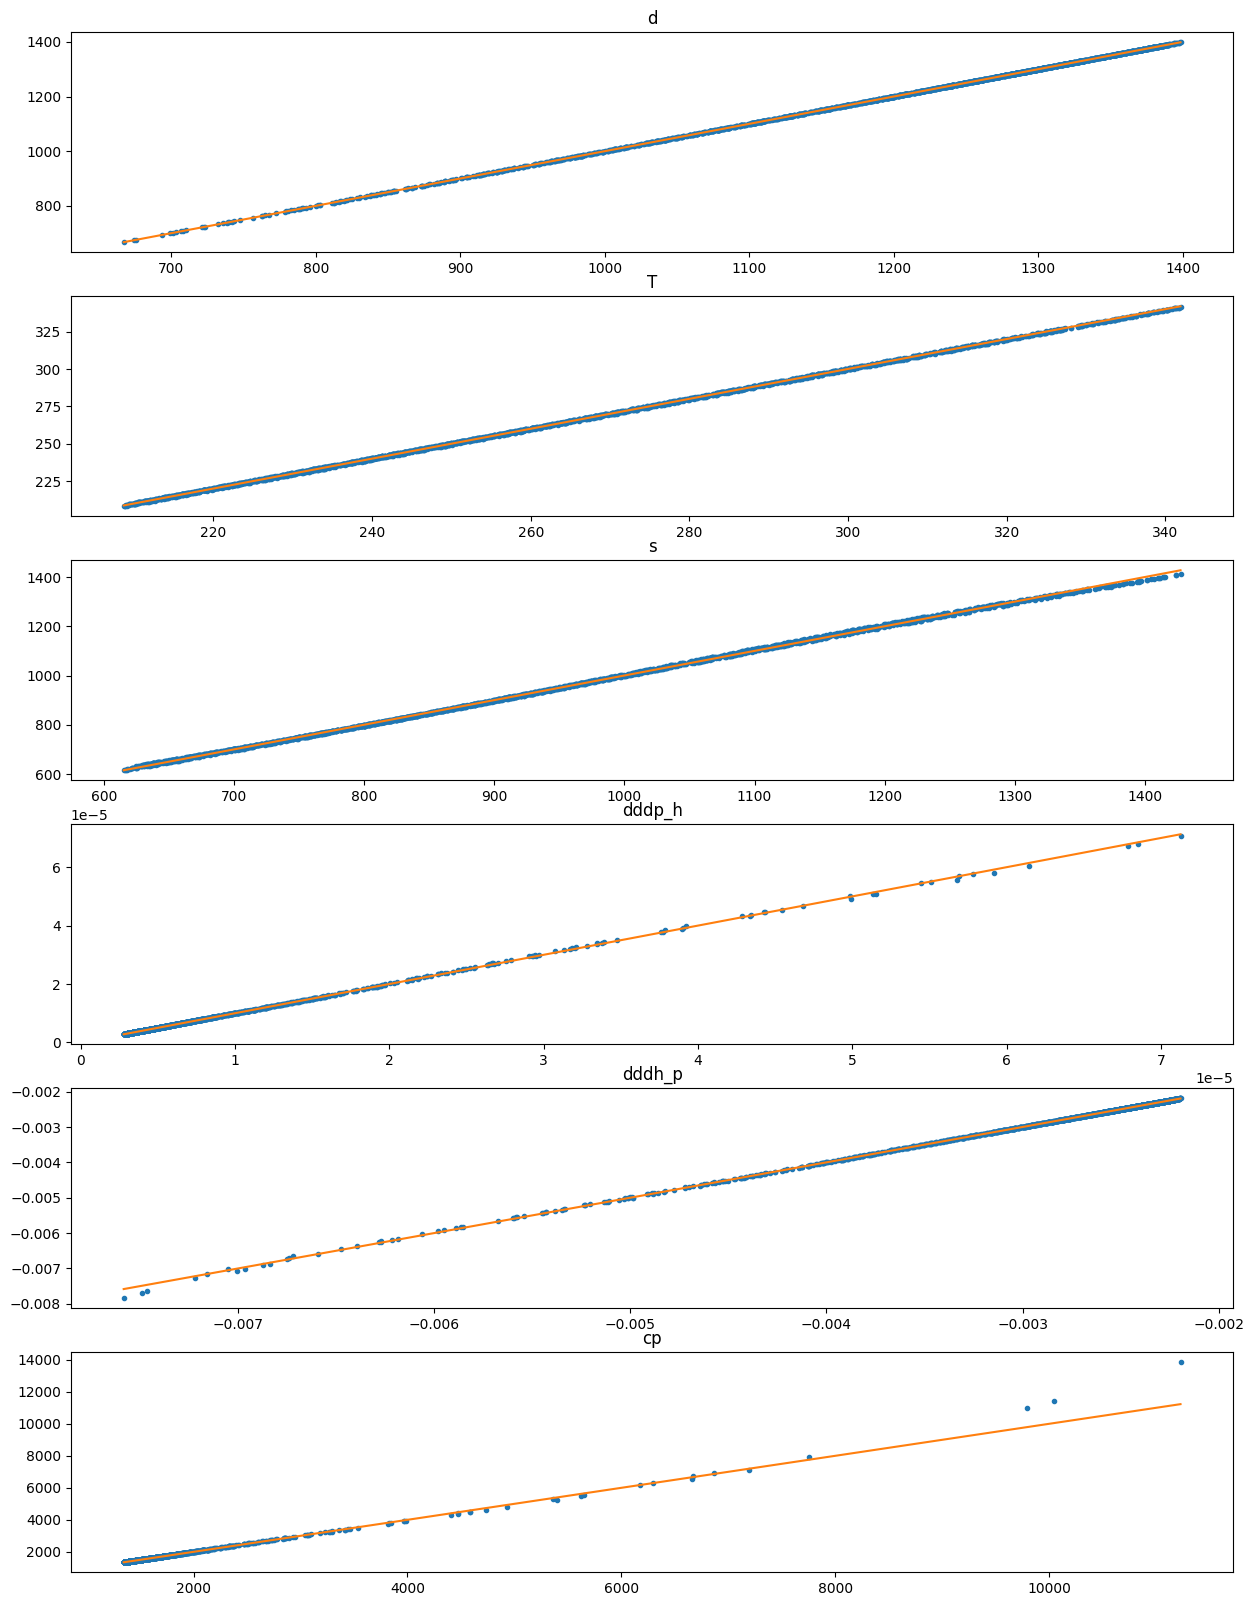

In [22]:
medium = 'R410A'
p_crit = PropsSI('Pcrit', medium)
p_min = 1.1e5
p_max = p_crit * 0.95
h_min = 1.1e5
h_max = 4.9e5
criterion = MSELoss()
normalizer = MinMaxScaler()

N = 10
n_input = 2
n_output = 3
phase = 'liquid'
net = nn.Sequential(nn.Linear(n_input, N),
                    nn.Sigmoid(),
                    nn.Linear(N, N),
                    nn.Sigmoid(),
                    nn.Linear(N, n_output))
model = PINNmodel(medium, p_max, p_min, h_max, h_min, net, criterion, normalizer)
model.train_singlePhase(100, 100, phase, 50, 5)
_ = model.validate_singlePhase(50, 50, phase, mean_absolute_percentage_error)

# train saturated
# N = 10
# n_input = 1
# n_output = 4
# phase = 'dew'
# net = nn.Sequential(nn.Linear(n_input, N),
#                     nn.Sigmoid(),
#                     nn.Linear(N, n_output))
# model = PINNmodel(medium, p_max, p_min, h_max, h_min, net, criterion, normalizer)
# model.train_sat(1000, phase, 40, 1)
# e_output, e_deriv = model.validate_sat(1200, phase, mean_absolute_percentage_error)

In [5]:
# save model
model.save_model('R410a_dew')

In [ ]:
for name, param in model.net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param}")

Layer: 0.weight | Size: torch.Size([7, 1]) | Values: Parameter containing:
tensor([[  3.2205],
        [  7.3654],
        [  1.0886],
        [ 69.9706],
        [ 30.4873],
        [-17.8004],
        [-18.0550]], requires_grad=True)
Layer: 0.bias | Size: torch.Size([7]) | Values: Parameter containing:
tensor([  3.1658, -11.1902,  -3.2105,   5.0272, -36.8446,  -4.6042,  -4.1736],
       requires_grad=True)
Layer: 2.weight | Size: torch.Size([4, 7]) | Values: Parameter containing:
tensor([[ 6.5488e-01,  9.6985e+00,  1.0778e+01,  3.0888e-03,  1.7653e+01,
          4.9222e+00, -3.3341e+00],
        [ 2.5789e+01, -1.9758e+01, -1.6301e+01,  1.0489e+01, -2.8713e+01,
          1.5767e+00, -2.2122e+01],
        [ 1.4131e+01, -1.1864e+00,  4.2286e+00,  4.9973e+00,  1.0840e+00,
         -6.2724e+00, -6.0425e+00],
        [-6.7920e+00, -5.1886e+00, -5.6735e+00, -7.5357e+00, -8.3826e+00,
          9.1051e-01,  1.1012e+01]], requires_grad=True)
Layer: 2.bias | Size: torch.Size([4]) | Values: Para

### Load network weights

In [6]:
file_path = 'R410a_liquid.pth'
model = torch.load(file_path)
model_weights = model.state_dict()
weights = {k: v.detach().numpy() for k, v in model_weights.items()}

# Save weights to a text file
with open('weights.txt', 'w') as f:
    for key, value in weights.items():
        f.write(f"{key}: {value.tolist()}\n")

<ipython-input-6-a22b24a50416>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(file_path)


In [7]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=8, out_features=3, bias=True)
)
